In [1]:
# Cell 1: Load Saved Data
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')

# Load saved data
print("Loading data...")

with open('../data/price_data.pkl', 'rb') as f:
    price_data = pickle.load(f)

with open('../data/financial_data.pkl', 'rb') as f:
    financial_data = pickle.load(f)

with open('../data/tickers.pkl', 'rb') as f:
    tickers = pickle.load(f)

print(f"\u2713 Loaded data:")
print(f"  - Price data: {len(price_data)} companies")
print(f"  - Financial data: {len(financial_data)} companies")
print(f"  - Tickers: {len(tickers)} companies")

# Check data quality
print(f"\nPrice data sample (first ticker):")
sample_ticker = list(price_data.keys())[0]
print(f"Ticker: {sample_ticker}")
print(price_data[sample_ticker].head())

Loading data...
✓ Loaded data:
  - Price data: 10 companies
  - Financial data: 10 companies
  - Tickers: 10 companies

Price data sample (first ticker):
Ticker: AAPL
               Open     High      Low    Close     Volume  Adj Close
date                                                                
2013-02-08  67.7142  68.4014  66.8928  67.8542  158168416    67.8542
2013-02-11  68.0714  69.2771  67.6071  68.5614  129029425    68.5614
2013-02-12  68.5014  68.9114  66.8205  66.8428  151829363    66.8428
2013-02-13  66.7442  67.6628  66.1742  66.7156  118721995    66.7156
2013-02-14  66.3599  67.3771  66.2885  66.6556   88809154    66.6556


In [2]:
# Cell 2: Debug - Inspect data structure
print("=== DEBUG: Inspecting data structure ===")

sample_company = financial_data[0]
ticker = sample_company['ticker']
income = sample_company['quarterly_income']

print(f"\nTicker: {ticker}")
print(f"Income statement shape: {income.shape}")
print(f"Index (rows): {list(income.index)}")
print(f"First 5 columns (dates): {list(income.columns[:5])}")
print(f"\nSample data (first 3 quarters):")
print(income.iloc[:, :3])

# Check price data date range
print(f"\n=== Price data for {ticker} ===")
prices = price_data[ticker]
print(f"Date range: {prices.index.min()} to {prices.index.max()}")

# Test reading a value
print(f"\n=== Testing data access ===")
test_quarter = income.columns[0]
print(f"Test quarter: {test_quarter}")
print(f"'Total Revenue' in index? {'Total Revenue' in income.index}")
print(f"test_quarter in columns? {test_quarter in income.columns}")
if 'Total Revenue' in income.index:
    val = income.loc['Total Revenue', test_quarter]
    print(f"Revenue via .loc: {val:,.0f}")

# Check quarter overlap with price data
print(f"\n=== Checking date overlap ===")
price_min = prices.index.min()
price_max = prices.index.max()
for q in income.columns[:10]:
    q_ts = pd.Timestamp(q)
    future_date = q_ts + pd.Timedelta(days=90)
    in_range = price_min <= q_ts <= price_max
    future_in_range = price_min <= future_date <= price_max
    status = "VALID" if (in_range and future_in_range) else "skip"
    print(f"  {q.date()}: quarter={in_range}, +90d={future_in_range} [{status}]")

=== DEBUG: Inspecting data structure ===

Ticker: AAPL
Income statement shape: (3, 40)
Index (rows): ['Total Revenue', 'Gross Profit', 'Net Income']
First 5 columns (dates): [Timestamp('2016-06-30 00:00:00'), Timestamp('2016-09-30 00:00:00'), Timestamp('2016-12-31 00:00:00'), Timestamp('2017-03-31 00:00:00'), Timestamp('2017-06-30 00:00:00')]

Sample data (first 3 quarters):
                 2016-06-30    2016-09-30    2016-12-31
Total Revenue  9.223521e+10  9.005814e+10  9.009828e+10
Gross Profit   4.118703e+10  3.999901e+10  4.176632e+10
Net Income     2.273998e+10  2.198739e+10  2.374666e+10

=== Price data for AAPL ===
Date range: 2013-02-08 00:00:00 to 2018-02-07 00:00:00

=== Testing data access ===
Test quarter: 2016-06-30 00:00:00
'Total Revenue' in index? True
test_quarter in columns? True
Revenue via .loc: 92,235,213,689

=== Checking date overlap ===
  2016-06-30: quarter=True, +90d=True [VALID]
  2016-09-30: quarter=True, +90d=True [VALID]
  2016-12-31: quarter=True, +90d=T

In [3]:
# Cell 3: Feature Engineering Function (FIXED)
# Data structure: rows = metrics, columns = quarter dates
# Must use .loc[row_name, col_name] to access values

from datetime import datetime, timedelta

def safe_loc(df, row_name, col_name):
    """Safely extract numeric value using df.loc[row, col]."""
    try:
        if row_name in df.index and col_name in df.columns:
            value = df.loc[row_name, col_name]
            if pd.isna(value):
                return 0
            return float(value)
    except:
        pass
    return 0

def create_features(financial_data, price_data):
    """Transform raw financial data into ML-ready features."""
    all_samples = []
    skipped = {'no_revenue': 0, 'no_prices': 0, 'no_quarter_price': 0, 'no_future_price': 0}

    for company in financial_data:
        ticker = company['ticker']
        income = company.get('quarterly_income')
        balance = company.get('quarterly_balance')

        if income is None or income.empty:
            continue

        if ticker not in price_data:
            skipped['no_prices'] += 1
            continue

        ticker_prices = price_data[ticker]['Adj Close']
        quarters = list(income.columns)

        for i in range(len(quarters) - 1):
            current_quarter = quarters[i]
            next_quarter = quarters[i + 1]

            # Extract using .loc[metric_name, date]
            revenue = safe_loc(income, 'Total Revenue', current_quarter)
            gross_profit = safe_loc(income, 'Gross Profit', current_quarter)
            net_income_val = safe_loc(income, 'Net Income', current_quarter)
            next_revenue = safe_loc(income, 'Total Revenue', next_quarter)

            if revenue == 0:
                skipped['no_revenue'] += 1
                continue

            # Balance sheet
            total_assets = 0
            total_debt = 0
            if balance is not None and not balance.empty:
                total_assets = safe_loc(balance, 'Total Assets', current_quarter)
                total_debt = safe_loc(balance, 'Total Debt', current_quarter)

            # Derived features
            revenue_growth = (next_revenue - revenue) / revenue if next_revenue != 0 else 0
            profit_margin = net_income_val / revenue
            gross_margin = gross_profit / revenue
            debt_to_assets = total_debt / total_assets if total_assets != 0 else 0

            # Match stock prices
            quarter_end = pd.Timestamp(current_quarter)

            mask = (ticker_prices.index >= quarter_end - pd.Timedelta(days=7)) & \
                   (ticker_prices.index <= quarter_end + pd.Timedelta(days=7))
            if not mask.any():
                skipped['no_quarter_price'] += 1
                continue
            quarter_price = ticker_prices[mask].iloc[0]

            future_date = quarter_end + pd.Timedelta(days=90)
            mask_future = (ticker_prices.index >= future_date - pd.Timedelta(days=7)) & \
                          (ticker_prices.index <= future_date + pd.Timedelta(days=7))
            if not mask_future.any():
                skipped['no_future_price'] += 1
                continue
            future_price = ticker_prices[mask_future].iloc[0]

            stock_return = (future_price - quarter_price) / quarter_price

            all_samples.append({
                'ticker': ticker,
                'date': current_quarter,
                'revenue': revenue,
                'revenue_growth': revenue_growth,
                'profit_margin': profit_margin,
                'gross_margin': gross_margin,
                'net_income': net_income_val,
                'total_assets': total_assets,
                'debt_to_assets': debt_to_assets,
                'quarter_price': quarter_price,
                'target_return': stock_return
            })

    print(f"Skipped reasons: {skipped}")
    return pd.DataFrame(all_samples)

print("\u2713 Feature engineering function defined")

✓ Feature engineering function defined


In [4]:
# Cell 4: Create Feature Dataset
print("Creating feature dataset...")

dataset = create_features(financial_data, price_data)

print(f"\n\u2713 Created dataset with {len(dataset)} samples")
print(f"Dataset shape: {dataset.shape}")
print(f"\nFirst few rows:")
print(dataset.head())

if len(dataset) > 0:
    print(f"\nFeature statistics:")
    print(dataset.describe())
    print(f"\nSamples per company:")
    print(dataset['ticker'].value_counts())
else:
    print("\nNo samples created - check debug cell above for details")

Creating feature dataset...
Skipped reasons: {'no_revenue': 0, 'no_prices': 0, 'no_quarter_price': 320, 'no_future_price': 10}

✓ Created dataset with 60 samples
Dataset shape: (60, 11)

First few rows:
  ticker       date       revenue  revenue_growth  profit_margin  \
0   AAPL 2016-06-30  9.223521e+10       -0.023604       0.246543   
1   AAPL 2016-09-30  9.005814e+10        0.000446       0.244147   
2   AAPL 2016-12-31  9.009828e+10        0.049382       0.263564   
3   AAPL 2017-03-31  9.454754e+10       -0.050265       0.202168   
4   AAPL 2017-06-30  8.979514e+10        0.144666       0.257856   

   gross_margin    net_income  total_assets  debt_to_assets  quarter_price  \
0      0.446543  2.273998e+10  2.946275e+11        0.368536          96.10   
1      0.444147  2.198739e+10  3.128407e+11        0.334535         112.71   
2      0.463564  2.374666e+10  2.577689e+11        0.279042         117.26   
3      0.402168  1.911449e+10  2.347166e+11        0.274697         140.64  

In [5]:
# Cell 5: Data Cleaning

print(f"Original dataset: {len(dataset)} samples")

# Remove extreme outliers (stock returns beyond +/-100%)
dataset = dataset[dataset['target_return'].between(-1, 1)]
print(f"After removing extreme returns: {len(dataset)} samples")

# Remove infinite values
dataset = dataset.replace([np.inf, -np.inf], np.nan)
dataset = dataset.dropna()
print(f"After removing NaN/inf: {len(dataset)} samples")

# Remove negative financial values (data errors)
dataset = dataset[dataset['revenue'] > 0]
dataset = dataset[dataset['total_assets'] > 0]
print(f"After removing invalid financials: {len(dataset)} samples")

print(f"\n\u2713 Final cleaned dataset: {len(dataset)} samples")

if len(dataset) < 50:
    print("\nNote: Limited samples - expected with synthetic data and 10 companies")
elif len(dataset) < 200:
    print("\nNote: Limited samples - typical for a prototype with 10 companies")
else:
    print("\n\u2713 Good sample size for prototype!")

# Save processed dataset
dataset.to_csv('../data/processed_dataset.csv', index=False)
print("\u2713 Saved to data/processed_dataset.csv")

Original dataset: 60 samples
After removing extreme returns: 60 samples
After removing NaN/inf: 60 samples
After removing invalid financials: 60 samples

✓ Final cleaned dataset: 60 samples

Note: Limited samples - typical for a prototype with 10 companies
✓ Saved to data/processed_dataset.csv


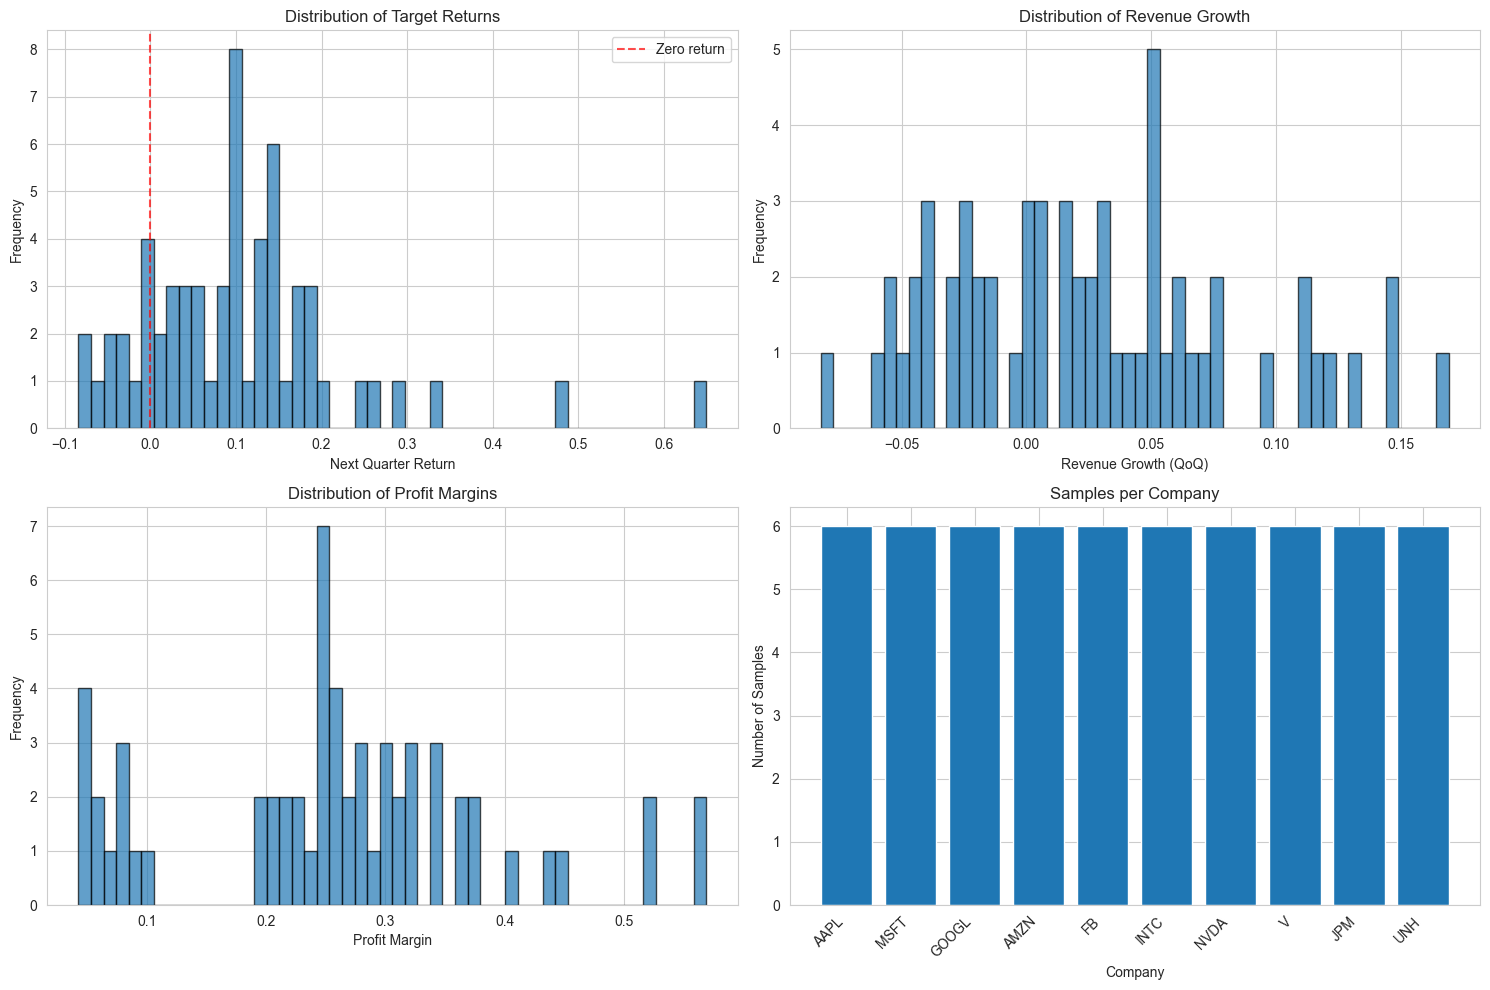

✓ Saved visualization to results/data_exploration.png


In [6]:
# Cell 6: Quick Data Exploration
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(dataset['target_return'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Next Quarter Return')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Target Returns')
axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Zero return')
axes[0, 0].legend()

axes[0, 1].hist(dataset['revenue_growth'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Revenue Growth (QoQ)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Revenue Growth')

axes[1, 0].hist(dataset['profit_margin'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Profit Margin')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Profit Margins')

samples_per_company = dataset['ticker'].value_counts()
axes[1, 1].bar(range(len(samples_per_company)), samples_per_company.values)
axes[1, 1].set_xlabel('Company')
axes[1, 1].set_ylabel('Number of Samples')
axes[1, 1].set_title('Samples per Company')
axes[1, 1].set_xticks(range(len(samples_per_company)))
axes[1, 1].set_xticklabels(samples_per_company.index, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../results/data_exploration.png', dpi=150, bbox_inches='tight')
plt.show()

print("\u2713 Saved visualization to results/data_exploration.png")